# Demand Curve Fitting

## Data

- $q_L = 100 - p + \epsilon$, Linear Model
- $q_E = e^{4.5 - 0.5 \ln p} + \epsilon$
- $q_S = \dfrac{C}{1 + e^{\alpha (p - p_0)}} + \epsilon$

In [1]:
import pandas as pd
import numpy as np
import random

def lin(p, b_0, b_1):
    e = np.random.normal(10, 5, p.shape[0])
    return b_0 + b_1 * p + e

def exp(p, b_0, b_1):
    e = np.random.normal(10, 5, p.shape[0])
    return np.exp(b_0 + b_1 * np.log(p)) + e

def sig(p, C, alpha, p_0):
    e = np.random.normal(10, 5, p.shape[0])
    return (C / (1 + np.exp(alpha * (p - p_0)))) + e

random.seed(37)
np.random.seed(37)

df = pd.DataFrame({
        'p': np.arange(1, 101, 1)
    }) \
    .assign(
        q_lin=lambda d: lin(d['p'], 100, -1, ),
        q_exp=lambda d: exp(d['p'], 4.5, -0.5),
        q_sig=lambda d: sig(d['p'], 100, 0.2, 50) 
    )
df.shape

(100, 4)

<Axes: title={'center': 'Simulated data'}, xlabel='p', ylabel='quantity'>

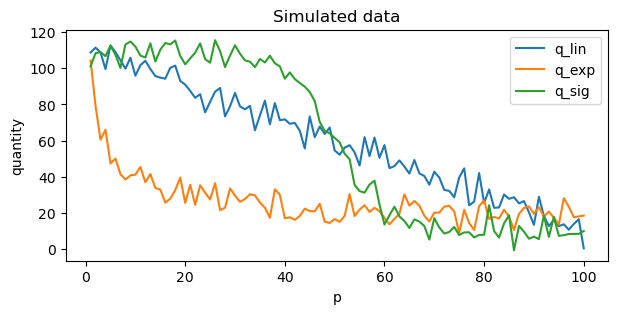

In [2]:
df \
    .set_index(['p'])[['q_lin', 'q_exp', 'q_sig']] \
    .plot(kind='line', figsize=(7, 3), title='Simulated data', ylabel='quantity')

## Curve fitting

In [3]:
def lin_decay(p, b_0, b_1):
    return b_0 + b_1 * p

def exp_decay(p, b_0, b_1):
    return np.exp(b_0 + b_1 * np.log(p))

def sig_decay(p, C, alpha, p_0):
    return (C / (1 + np.exp(alpha * (p - p_0))))

In [4]:
from scipy.optimize import curve_fit

x = df['p']
y = df['q_lin']
p_hat = [y.mean(), x.mean()]
lin_opt, _ = curve_fit(lin_decay, x, y, p_hat, method='dogbox', maxfev=1_000)
lin_opt

array([110.98049872,  -1.01340002])

In [5]:
x = df['p']
y = df['q_exp']
p_hat = [y.mean(), -x.mean()]
exp_opt, _ = curve_fit(exp_decay, x, y, p_hat, method='dogbox', maxfev=1_000)
exp_opt

array([ 4.6059456 , -0.38579319])

In [6]:
x = df['p']
y = df['q_sig']
p_hat = [x.max(), 1.0, x.mean()]
sig_opt, _ = curve_fit(sig_decay, x, y, p_hat, method='dogbox', maxfev=1_000)
sig_opt

array([110.46212889,   0.14834146,  51.83058679])

## Errors

In [7]:
pred_df = df \
    .assign(
        y_lin=lambda d: lin_decay(d['p'], lin_opt[0], lin_opt[1]),
        y_exp=lambda d: exp_decay(d['p'], exp_opt[0], exp_opt[1]),
        y_sig=lambda d: sig_decay(d['p'], sig_opt[0], sig_opt[1], sig_opt[2]),
        tr_lin=lambda d: d['p'] * d['y_lin'],
        tr_exp=lambda d: d['p'] * d['y_exp'],
        tr_sig=lambda d: d['p'] * d['y_sig'],
        lin_mae=lambda d: np.abs(d['q_lin'] - d['y_lin']),
        exp_mae=lambda d: np.abs(d['q_exp'] - d['y_exp']),
        sig_mae=lambda d: np.abs(d['q_sig'] - d['y_sig']),
        lin_mape=lambda d: np.abs(d['q_lin'] - d['y_lin']) / d['q_lin'],
        exp_mape=lambda d: np.abs(d['q_exp'] - d['y_exp']) / d['q_exp'],
        sig_mape=lambda d: np.abs(d['q_sig'] - d['y_sig']) / d['q_sig'],
        lin_wape=lambda d: np.abs(d['q_lin'] - d['y_lin']) / d['q_lin'].sum(),
        exp_wape=lambda d: np.abs(d['q_exp'] - d['y_exp']) / d['q_exp'].sum(),
        sig_wape=lambda d: np.abs(d['q_sig'] - d['y_sig']) / d['q_sig'].sum()
    )

pred_df \
    [['lin_mae', 'exp_mae', 'sig_mae', 
      'lin_mape', 'exp_mape', 'sig_mape', 
      'lin_wape', 'exp_wape', 'sig_wape']] \
    .mean()

lin_mae     4.084114
exp_mae     4.080262
sig_mae     5.422417
lin_mape    0.250673
exp_mape    0.184561
sig_mape    0.284749
lin_wape    0.000683
exp_wape    0.001531
sig_wape    0.000916
dtype: float64

## Visualize curve fits

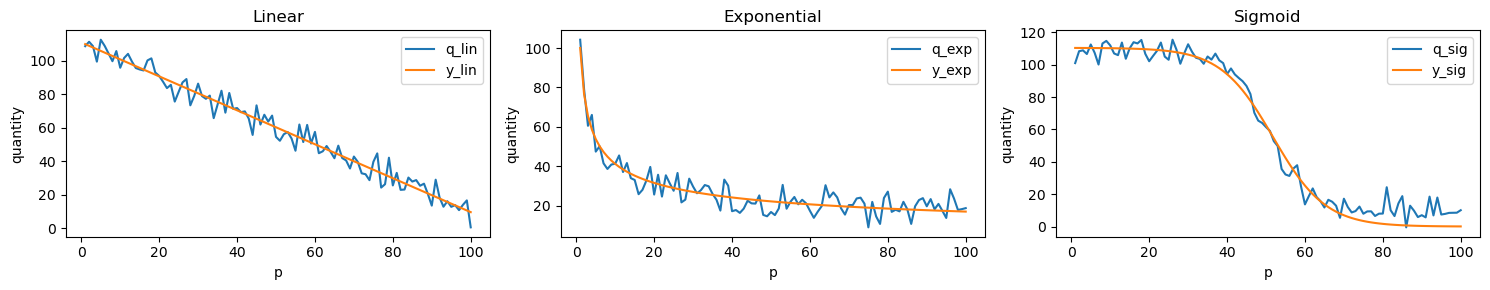

In [8]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 3, figsize=(15, 3))

pred_df \
    .set_index(['p']) \
    [['q_lin', 'y_lin']] \
    .plot(kind='line', ax=ax[0], title='Linear', ylabel='quantity')

pred_df \
    .set_index(['p']) \
    [['q_exp', 'y_exp']] \
    .plot(kind='line', ax=ax[1], title='Exponential', ylabel='quantity')

pred_df \
    .set_index(['p']) \
    [['q_sig', 'y_sig']] \
    .plot(kind='line', ax=ax[2], title='Sigmoid', ylabel='quantity')

fig.tight_layout()

C:\Users\super\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



<Axes: xlabel='p', ylabel='tr_lin'>

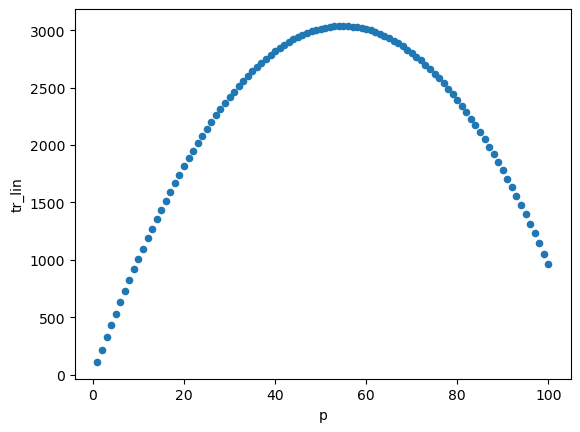

In [36]:
pred_df.plot(kind='scatter', x='p', y='tr_lin')

<Axes: xlabel='p', ylabel='tr_exp'>

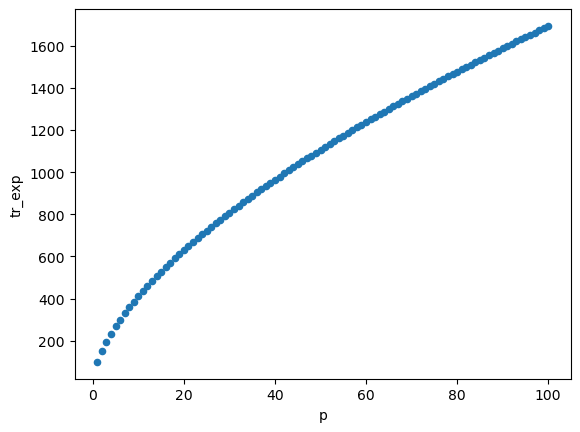

In [37]:
pred_df.plot(kind='scatter', x='p', y='tr_exp')

<Axes: xlabel='p', ylabel='tr_sig'>

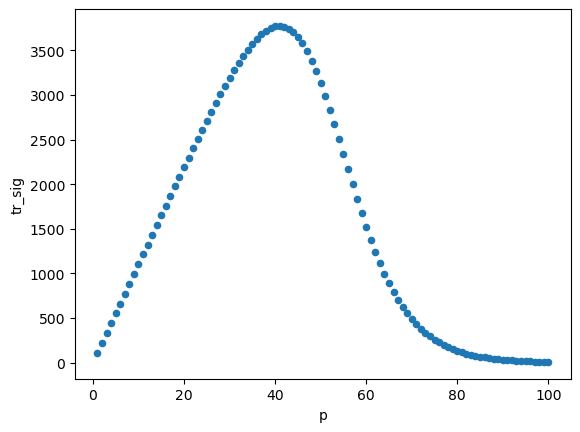

In [38]:
pred_df.plot(kind='scatter', x='p', y='tr_sig')